In [1]:
from pathlib import Path
import time
import torch
import numpy as np
from dataset import LinearDynamicalDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
#import plotly.graph_objects as go
from transformer_onestep import GPTConfig, GPT
import tqdm
import argparse
import metrics

In [2]:
fig_path = Path("fig")
fig_path.mkdir(exist_ok=True)

In [3]:
torch.manual_seed(420)
np.random.seed(430)

In [4]:
# Overall settings
out_dir = "out"

# System settings
nx = 10
nu = 1
ny = 1
seq_len = 400


# Compute settings
cuda_device = "cuda:1"
no_cuda = True
threads = 5
compile = True

# Configure compute
torch.set_num_threads(threads)
use_cuda = not no_cuda and torch.cuda.is_available()
device_name  = cuda_device if use_cuda else "cpu"
device = torch.device(device_name)
device_type = 'cuda' if 'cuda' in device_name else 'cpu' # for later use in torch.autocast
torch.set_float32_matmul_precision("high")
#torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
#torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn

# Create out dir
out_dir = Path(out_dir)
exp_data = torch.load(out_dir/"ckpt_onestep_lin.pt", map_location=device)


# Create data loader
test_ds = LinearDynamicalDataset(nx=nx, nu=nu, ny=ny, seq_len=seq_len)
test_dl = DataLoader(test_ds, batch_size=256, num_workers=threads)

model_args = exp_data["model_args"]
gptconf = GPTConfig(**model_args)
model = GPT(gptconf).to(device)


state_dict = exp_data["model"]
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict);

number of parameters: 1.63M


In [5]:
batch_y, batch_u = next(iter(test_dl))
with torch.no_grad():
    batch_y_pred, loss = model(batch_u, batch_y)
    batch_y_pred = batch_y_pred.detach().numpy()
    batch_y = batch_y.detach().numpy()
    batch_u = batch_u.detach().numpy()

In [6]:
batch_y_target = batch_y[:, 1:, :] # target @ time k: y_{k+1}
batch_y_pred = batch_y_pred[:, :-1, :] # prediction @ time k: y_{k+1|k}
batch_y_pred_dummy = batch_y[:, :-1, :] # dummy estimator: y_{k+1} \approx y_{k}
batch_pred_err = batch_y_target - batch_y_pred
batch_pred_err_dummy = batch_y_target - batch_y_pred_dummy

In [7]:
import matplotlib
matplotlib.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica'], 'size': 14})
matplotlib.rc('text', usetex=True)
matplotlib.rc('axes', grid=True)

In [8]:
t = np.arange(1, batch_y.shape[1])

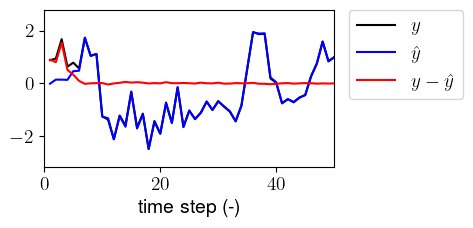

In [9]:
plt.figure(figsize=(5, 2.5))

idx = 7
plt.plot(t, batch_y_target[idx], 'k', label="$y$")
plt.plot(t, batch_y_pred[idx], 'b', label="$\hat y$")
#plt.plot(batch_y_pred_dummy[idx], 'm', label="Pred dummy")
plt.plot(t, batch_y_target[idx] - batch_y_pred[idx], 'r', label="$y - \hat y$")
#plt.plot(batch_y_target[idx] - batch_y_pred_dummy[idx], 'm', label="Err dummy")
#plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.xlim([0, 50]);
#plt.ylim([-3, 3]);
plt.xlabel("time step (-)")
plt.tight_layout()
plt.savefig(fig_path / "lin_one_step_single.pdf")

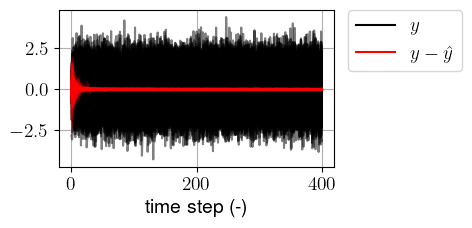

In [10]:
plt.figure(figsize=(5, 2.5))
#plt.title("Prediction error $y - \hat y$ on 256 sequences")
plt.plot(t, batch_y_target.squeeze(-1).T, "k", alpha=0.5);
plt.plot(t, batch_y_target.squeeze(-1).T[:, -1], "k", alpha=1.0, label="$y$")
plt.plot(t, batch_pred_err.squeeze(-1).T, "r", alpha=0.2);
plt.plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
plt.grid(True)
plt.xlabel("time step (-)")
#plt.legend(loc="upper right")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
#plt.xlabel("Time step $k$");
plt.savefig(fig_path / "lin_one_step_batch.pdf")

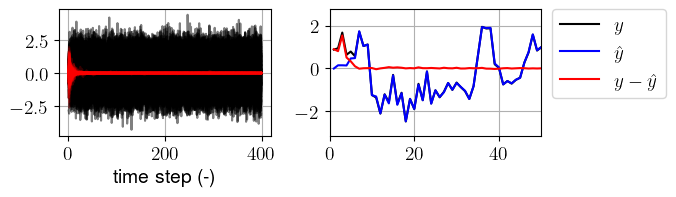

In [11]:
fix, ax = plt.subplots(1,2, figsize=(7, 2.2))
ax[0].plot(t, batch_y_target.squeeze(-1).T, "k", alpha=0.5);
ax[0].plot(t, batch_y_target.squeeze(-1).T[:, -1], "k", alpha=1.0, label="$y$")
ax[0].plot(t, batch_pred_err.squeeze(-1).T, "r", alpha=0.2);
ax[0].plot(t, np.nan*np.zeros(t.shape), "r", alpha=1.0, label="$y - \hat y$");
ax[0].set_xlabel("time step (-)")

ax[1].plot(t, batch_y_target[idx], 'k', label="$y$")
ax[1].plot(t, batch_y_pred[idx], 'b', label="$\hat y$")
ax[1].plot(t, batch_y_target[idx] - batch_y_pred[idx], 'r', label="$y - \hat y$")
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax[1].set_xlim([0, 50]);
plt.tight_layout()
plt.savefig(fig_path / "lin_one_step_batch_single.pdf")

In [12]:
skip = 50
rmse_transformer = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred[:, skip:, :], time_axis=1)
rmse_dummy = metrics.rmse(batch_y_target[:, skip:, :], batch_y_pred_dummy[:, skip:, :], time_axis=1)

In [13]:
#print(f'iterations: {exp_data["cfg"].max_iters}')
print(f'train_time: {exp_data["train_time"]/3600} hours')
print(f'rmse: {rmse_transformer.mean()}')

train_time: 2.3741475400659775 hours
rmse: 0.0090656578540802
